# 目录
1. [数据读取与章节整合整合](#1.数据读取与整合) 
2. [剧情趋势和人物词频分析](#2.剧情趋势和人物词频分析)  
3. [红楼梦章节聚类及可视化](#3.红楼梦章节聚类及可视化)
7. [总结](#7.总结)

<div id="1"></div>
# 1.数据读取与整合

In [3]:
## 加载数据包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.sans-serif']=['SimHei']   # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False     # 用来正常显示负号
matplotlib.rc("font",family='Heiti TC')
%matplotlib inline
import jieba
import nltk

import warnings
warnings.filterwarnings('ignore')

数据集介绍如下：
+ `Dream_of_the_Red_Mansion.txt`为红楼梦小说的txt版本，编码格式为utf-8。
+ `Red_Mansion_Dictionary.txt`为包含红楼梦中专有人物的词典，用于辅助分词。
+ `stop_words.txt`为停用词表，包含数字、特殊符号等常见的停用词。

In [4]:
## 设置显示偏好
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",None)

## 读取文章、停用词和需要的词典
stop_words = pd.read_csv("./input/stop_words.txt",header=None,names = ["stop_words"])
dictionary = pd.read_csv("./input/Red_Mansion_Dictionary.txt",header=None, names=["dictionary"])
content = pd.read_csv("./input/Dream_of_the_Red_Mansion.txt",header=None,names = ["content"])

print(content.head(),'\n\n',dictionary.head(),'\n\n',stop_words.head())

                                             content
0                                                第1卷
1                              第一回 甄士隐梦幻识通灵 贾雨村风尘怀闺秀
2  　　此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借“通灵”之说，撰此<<...
3                 　　此回中凡用“梦”用“幻”等字，是提醒阅者眼目，亦是此书立意本旨。
4  　　列位看官：你道此书从何而来？说起根由虽近荒唐，细按则深有趣味。待在下将此来历注明，方使阅... 

   dictionary
0         黛玉
1         宝钗
2         贾演
3         贾寅
4         贾源 

   stop_words
0          $
1          0
2          1
3          2
4          3


接下来我们需要对文本数据进行预处理，整合显示格式。首先需要分析的是读取的数据是否存在缺失值，可以使用Pandas中的`isnull()`函数进行判断。

In [5]:
## 查看文章是否有空白的行，如有则删除
np.sum(pd.isnull(content))  

content    0
dtype: int64

为了观察的美观和简便，我们删除`第1卷`、`第2卷`等文字占用的行，使用正则表达式进行匹配，将满足条件的索引进行筛选。

In [6]:
## 使用正则表达式，选取相应索引
index_of_juan = content.content.str.contains("^第+.+卷") 

## 根据索引删除不需要的行，并重新设置索引
content = content[~index_of_juan].reset_index(drop=True) 
content.head()

,content
0,第一回 甄士隐梦幻识通灵 贾雨村风尘怀闺秀
1,此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借“通灵”之说，撰此<<...
2,此回中凡用“梦”用“幻”等字，是提醒阅者眼目，亦是此书立意本旨。
3,列位看官：你道此书从何而来？说起根由虽近荒唐，细按则深有趣味。待在下将此来历注明，方使阅...
4,原来女娲氏炼石补天之时，于大荒山无稽崖练成高经十二丈，方经二十四丈顽石三万六千五百零一块...


接下来我们提取每个章节的标题，并进行字符的处理。

In [7]:
## 使用正则表达式，选取相应索引
index_of_hui = content.content.str.match("^第+.+回")

## 根据索引选取每一章节的标题
chapter_names = content.content[index_of_hui].reset_index(drop=True)
chapter_names.head()

0    第一回 甄士隐梦幻识通灵 贾雨村风尘怀闺秀
1    第二回 贾夫人仙逝扬州城 冷子兴演说荣国府
2    第三回 贾雨村夤缘复旧职 林黛玉抛父进京都
3    第四回 薄命女偏逢薄命郎 葫芦僧乱判葫芦案
4    第五回 游幻境指迷十二钗 饮仙醪曲演红楼梦
Name: content, dtype: object

In [8]:
## 处理章节名，按照空格分割字符串
chapter_names_split = chapter_names.str.split(" ").reset_index(drop=True)
chapter_names_split.head()

0    [第一回, 甄士隐梦幻识通灵, 贾雨村风尘怀闺秀]
1    [第二回, 贾夫人仙逝扬州城, 冷子兴演说荣国府]
2    [第三回, 贾雨村夤缘复旧职, 林黛玉抛父进京都]
3    [第四回, 薄命女偏逢薄命郎, 葫芦僧乱判葫芦案]
4    [第五回, 游幻境指迷十二钗, 饮仙醪曲演红楼梦]
Name: content, dtype: object

处理好章节标题后，接着我们计算每一章含有多少行、多少字，同时将每章节的内容进行整合，形成一个新的DataFrame对象。

In [9]:
## 建立保存数据的数据框
data = pd.DataFrame(list(chapter_names_split),columns=["chapter","left_name","right_name"])

## 添加章节序号和章节名称列
data["chapter_number"] = np.arange(1,121)
data["chapter_name"] = data.left_name+","+data.right_name

## 添加每章开始的行位置
data["start_id"] = index_of_hui[index_of_hui == True].index

## 添加每章结束的行位置
data["end_id"] = data["start_id"][1:len(data["start_id"])].reset_index(drop = True) - 1
data["end_id"][[len(data["end_id"])-1]] = content.index[-1]

## 添加每章的行数
data["length_of_chapters"] = data.end_id - data.start_id

data.head()

,chapter,left_name,right_name,chapter_number,chapter_name,start_id,end_id,length_of_chapters
0,第一回,甄士隐梦幻识通灵,贾雨村风尘怀闺秀,1,"甄士隐梦幻识通灵,贾雨村风尘怀闺秀",0,49.0,49.0
1,第二回,贾夫人仙逝扬州城,冷子兴演说荣国府,2,"贾夫人仙逝扬州城,冷子兴演说荣国府",50,79.0,29.0
2,第三回,贾雨村夤缘复旧职,林黛玉抛父进京都,3,"贾雨村夤缘复旧职,林黛玉抛父进京都",80,118.0,38.0
3,第四回,薄命女偏逢薄命郎,葫芦僧乱判葫芦案,4,"薄命女偏逢薄命郎,葫芦僧乱判葫芦案",119,148.0,29.0
4,第五回,游幻境指迷十二钗,饮仙醪曲演红楼梦,5,"游幻境指迷十二钗,饮仙醪曲演红楼梦",149,235.0,86.0


In [10]:
## 添加每章节的内容
data["content"] = ''

for i in data.index:
    ## 将内容使用""连接
    chapter_id = np.arange(data.start_id[i]+1,int(data.end_id[i]))
    ## 每章节的内容替换掉空格
    data["content"][i] = "".join(list(content.content[chapter_id])).replace("　　","")
    
## 添加每章字数
data["length_of_characters"] = data.content.apply(len)
data.head(2)

,chapter,left_name,right_name,chapter_number,chapter_name,start_id,end_id,length_of_chapters,content,length_of_characters
0,第一回,甄士隐梦幻识通灵,贾雨村风尘怀闺秀,1,"甄士隐梦幻识通灵,贾雨村风尘怀闺秀",0,49.0,49.0,此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借“通灵”之说，撰此<<石头...,7594
1,第二回,贾夫人仙逝扬州城,冷子兴演说荣国府,2,"贾夫人仙逝扬州城,冷子兴演说荣国府",50,79.0,29.0,诗云一局输赢料不真，香销茶尽尚逡巡。欲知目下兴衰兆，须问旁观冷眼人。却说封肃因听见公差传唤，...,5659


# 2.剧情趋势和人物词频分析

In [11]:
## 对红楼梦全文进行分词

## 数据表的行列数
row,col = data.shape

## 预定义列表
data["cutted_words"] = ''

# 指定自定义的词典，以便包含jieba词库里没有的词，保证更高的正确率
jieba.load_userdict('./input/Red_Mansion_Dictionary.txt')

for i in np.arange(row):
    ## 分词
    cutwords = list(jieba.cut(data.content[i]))
    ## 去除长度为1的词
    cutwords = pd.Series(cutwords)[pd.Series(cutwords).apply(len)>1]
    ## 去停用词
    cutwords = cutwords[~cutwords.isin(stop_words)]
    data.cutted_words[i] = cutwords.values

# 添加每一章节的词数
data['length_of_words'] = data.cutted_words.apply(len)
data['cutted_words'].head()

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/rj/kh58t7hj5s99k8krgn4brl1c0000gn/T/jieba.cache
Loading model cost 0.649 seconds.
Prefix dict has been built successfully.


0    [开卷, 第一回, 作者, 自云, 因曾, 历过, 一番, 梦幻, 之后, 真事, 隐去, ...
1    [诗云, 一局, 输赢, 料不真, 香销, 尽尚, 逡巡, 欲知, 目下, 兴衰, 旁观, ...
2    [却说, 雨村, 回头, 看时, 不是, 别人, 乃是, 当日, 同僚, 一案, 参革, 张...
3    [却说, 黛玉, 姊妹, 王夫人, 王夫人, 兄嫂, 计议, 家务, 姨母, 家遭, 人命官...
4    [第四回, 薛家, 母子, 荣府内, 寄居, 事略, 表明, 此回, 不能, 如今, 且说,...
Name: cutted_words, dtype: object

我们可以绘制散点图展示每一章节的段数、字数，以此来观察情节发展的趋势。

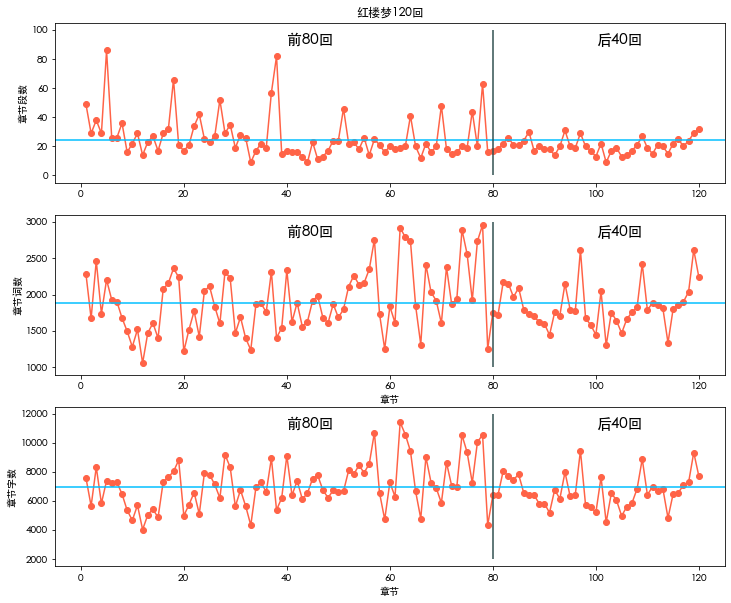

In [12]:
plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.plot(data.chapter_number,data.length_of_chapters,marker="o", linestyle="-",color = "tomato")

plt.ylabel("章节段数")
plt.title("红楼梦120回")
plt.hlines(np.mean(data.length_of_chapters),-5,125,"deepskyblue")
plt.vlines(80,0,100,"darkslategray")
plt.text(40,90,'前80回',fontsize = 15)
plt.text(100,90,'后40回',fontsize = 15)
plt.xlim((-5,125))

plt.subplot(3,1,2)
plt.plot(data.chapter_number,data.length_of_words,marker="o", linestyle="-",color = "tomato")
plt.xlabel("章节")
plt.ylabel("章节词数")
plt.hlines(np.mean(data.length_of_words),-5,125,"deepskyblue")
plt.vlines(80,1000,3000,"darkslategray")
plt.text(40,2800,'前80回',fontsize = 15)
plt.text(100,2800,'后40回',fontsize = 15)
plt.xlim((-5,125))

plt.subplot(3,1,3)
plt.plot(data.chapter_number,data.length_of_characters,marker="o", linestyle="-",color = "tomato")
plt.xlabel("章节")
plt.ylabel("章节字数")
plt.hlines(np.mean(data.length_of_characters),-5,125,"deepskyblue")
plt.vlines(80,2000,12000,"darkslategray")
plt.text(40,11000,'前80回',fontsize = 15)
plt.text(100,11000,'后40回',fontsize = 15)
plt.xlim((-5,125))

plt.show()

+ 蓝色线代表章节平均的段落数和字数，可以看到每一章平均段落数为25左右，平均次数为1900左右，平均字数为7000左右，在60-80回篇幅最多。
+ “红楼梦作者究竟是谁”这个问题引起中国文学界的漫长争论，并持续至今。众多学者认为曹雪芹的原著仅存80回，现存后40回是清人高鄂所续。我们根据灰色线将前80回和后40回进行划分，从这些相互关系可以看出，前80章和后40章还是有一些差异的。

在分词完成后，我们可以统计全书的词频，计算每个词出现的频率并排序。

In [13]:
words = np.concatenate(data.cutted_words)

#统计词频
word_df = pd.DataFrame({"word":words})
word_frequency = word_df.groupby(by=["word"])["word"].agg({"count"}).reset_index()
word_frequency.columns = ["word","frequency"]
word_frequency = word_frequency.reset_index().sort_values(by="frequency",ascending=False)

word_frequency.head(10)

,index,word,frequency
14636,14636,宝玉,3653
4190,4190,什么,1580
35,35,一个,1411
35237,35237,贾母,1235
18803,18803,我们,1189
7728,7728,凤姐,1160
37643,37643,那里,1143
33761,33761,袭人,1103
40529,40529,黛玉,996
13715,13715,如今,982


我们通过条形图将出现次数超过500的词语展示出来。

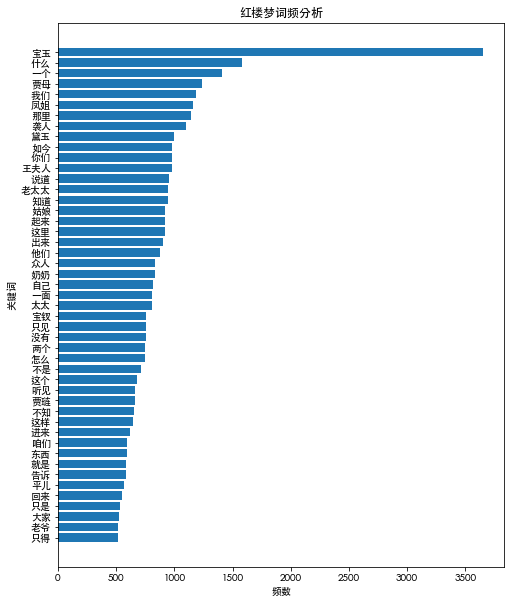

In [14]:
plt.figure(figsize=(8,10))

frequent_words = word_frequency.loc[word_frequency.frequency > 500].sort_values('frequency')
plt.barh(y = frequent_words["word"],width = frequent_words["frequency"])

plt.xticks(size = 10)  
plt.ylabel("关键词")   
plt.xlabel("频数")
plt.title("红楼梦词频分析")
plt.show()

从图中可以看出，宝玉出现的次数最多，是红楼梦中的主角。接下来我们通过Python中的wordcloud库进行词云绘制。

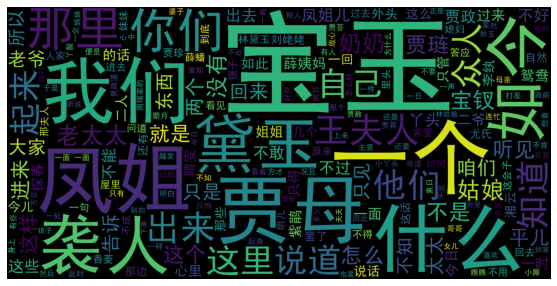

In [17]:
from wordcloud import WordCloud

plt.figure(figsize=(10,5))

wordcloud = WordCloud(font_path='./input/SimHei.ttf',margin=5, width=1800, height=900)

wordcloud.generate("/".join(np.concatenate(data.cutted_words)))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 构建词矩阵
在进行文本聚类之前，我们需要将词进行向量化，这里向量化的方式选用计算TF-IDF矩阵。

+ TF-IDF含义是词频逆文档频率，如果某个词在一篇文章中出现的频率高，并在其他文章中很少出现，则该词的重要性较高。词的重要性随着它在文件中出现的次数成正比增加，但同时会随着它在语料库中出现的频率成反比下降。
+ TfidfVectorizer模型建立后，可通过`fit_transform()`函数进行训练，将文本中的词语转换为词的TF－IDF矩阵；通过`get_feature_names()`可看到所有文本的关键字；通过`vocabulary_`属性查看关键词编号。TfidfVectorizer模型的输出为矩阵形式，通过`toarray()`函数可看到TF－IDF矩阵的结果。

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

content = []
for cutword in data.cutted_words:
    content.append(" ".join(cutword))

## 构建语料库，并计算文档的TF－IDF矩阵
transformer = TfidfVectorizer()
tfidf = transformer.fit_transform(content)

## TF－IDF以稀疏矩阵的形式存储，将TF－IDF转化为数组的形式,文档－词矩阵
word_vectors = tfidf.toarray()
word_vectors

array([[0.        , 0.        , 0.00732401, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0089662 , ..., 0.        , 0.        ,
        0.        ],
       [0.04321373, 0.        , 0.0486704 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00731152, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00886065, ..., 0.        , 0.        ,
        0.        ]])

# 3.红楼梦章节聚类及可视化

K-means聚类：对于给定的样本集A，按照样本之间的距离大小，将样本集A划分为K个簇$A_1,A_2,⋯,A_K$。让这些簇内的点尽量紧密的连在一起，而让簇间的距离尽量的大。

K-Means算法是无监督的聚类算法。目的是使得每个点都属于离它最近的均值（此即聚类中心）对应的簇$A_i$中。这里使用sklearn库中的K-means聚类算法对数据进行聚类分析，得到每一章所属的簇。

参数聚类数目`n_clusters = 3`，随机种子`random_state = 0`。

In [ ]:
from sklearn.cluster import KMeans

## 对word_vectors进行k均值聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(word_vectors)

## 聚类得到的类别
kmean_labels = data[["chapter_name","chapter"]]
kmean_labels["cluster"] = kmeans.labels_
kmean_labels

In [ ]:
## 查看每个簇有多少章节
count = kmean_labels.groupby("cluster")['chapter'].count()
count

我们通过设置簇的个数为3，可以大致衡量哪些章节的文字内容较为接近，如簇编号为2的章节有第4、79、80、91、103回等，说明这些章节的文本内容距离较近。接下来使用降维技术将TF-IDF矩阵降维，并将K-means聚类的簇对比降维数据进行可视化。

## 扩展学习

多维标度（Multidimensional scaling，缩写MDS，又译“多维尺度”）也称作“相似度结构分析”（Similarity structure analysis），属于多重变量分析的方法之一，是社会学、数量心理学、市场营销等统计实证分析的常用方法。MDS在降低数据维度的时候尽可能的保留样本之间的相对距离。

In [17]:
from sklearn.manifold import MDS

## 使用MDS对数据进行降维
mds = MDS(n_components=2,random_state=12)
mds_results = mds.fit_transform(word_vectors)
mds_results.shape

(120, 2)

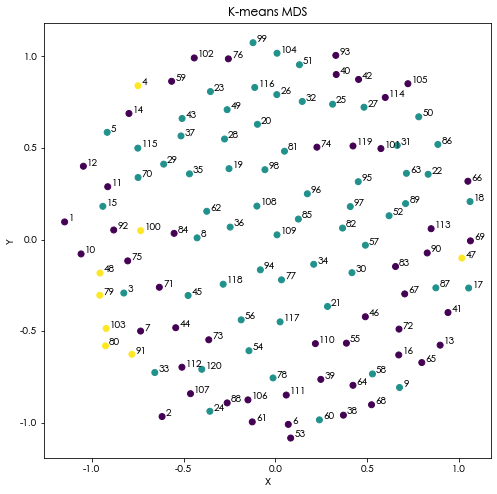

In [18]:
## 绘制降维后的结果
plt.figure(figsize=(8,8))
plt.scatter(mds_results[:,0],mds_results[:,1],c = kmean_labels.cluster)

for i in (np.arange(120)):
    plt.text(mds_results[i,0]+0.02,mds_results[i,1],s = data.chapter_number[i])
    
plt.xlabel("X")   
plt.ylabel("Y") 
plt.title("K-means MDS")
plt.show()

使用MDS将各章的词向量降至2维后，将K-means聚类的簇对比降维数据进行可视化，可以大致验证聚类结果的有效性。如簇0(紫色点)和簇2(黄色)分别展示在图的四周，簇1(绿色)的章节主要分布在图的中间，每个簇之间的章节相对距离较小。

PCA降维是一种常见的数据降维方法，其目的是在“信息”损失较小的前提下，将高维的数据转换到低维，从而减小计算量。PCA通常用于高维数据集的探索与可视化，还可以用于数据压缩，数据预处理等。

In [19]:
from sklearn.decomposition import PCA

## 使用PCA对数据进行降维
pca = PCA(n_components=2)

pca.fit(word_vectors)
print(pca.explained_variance_ratio_)

## 对数据降维
pca_results = pca.fit_transform(word_vectors)
print(pca_results.shape)

[0.037004   0.02803803]
(120, 2)


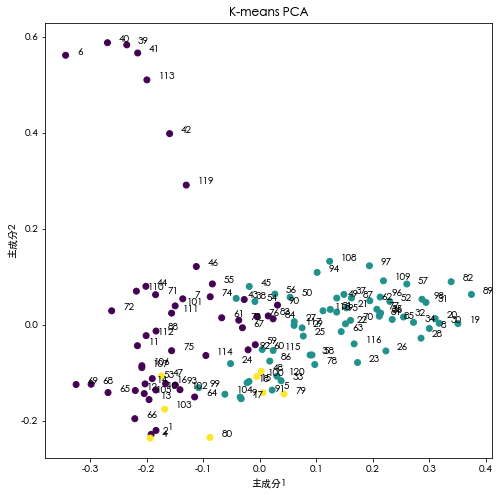

In [20]:
## 绘制降维后的结果
plt.figure(figsize=(8,8))
plt.scatter(pca_results[:,0],pca_results[:,1],c = kmean_labels.cluster)

for i in np.arange(120):
    plt.text(pca_results[i,0]+0.02,pca_results[i,1],s = data.chapter_number[i])
    
plt.xlabel("主成分1")   
plt.ylabel("主成分2")  
plt.title("K-means PCA")  
plt.show() 

使用PCA将各章的词向量降至2维后，将K-means聚类的簇对比降维数据进行可视化，可以得出相似的结论。簇2(黄色)的两个主成分相对较小，分布在图的左下部分较多，簇1(绿色)主成分相对较大，分布靠右，验证了聚类结果的有效性。

上面已经成功地使用K-means对文档进行聚类和绘图，现在可以试一下另外一种聚类算法。Ward聚类属于凝聚聚类算法，即每个处理阶段，将距离最小的两个对象分到一个类中。我使用预先计算的余弦距离矩阵计算出距离矩阵，然后将其绘制成树状图。


层次聚类(Hierarchical Clustering)是聚类算法的一种，通过计算不同类别数据点间的相似度来创建一棵有层次的嵌套聚类树。在聚类树中，不同类别的原始数据点是树的最低层，树的顶层是一个聚类的根节点。

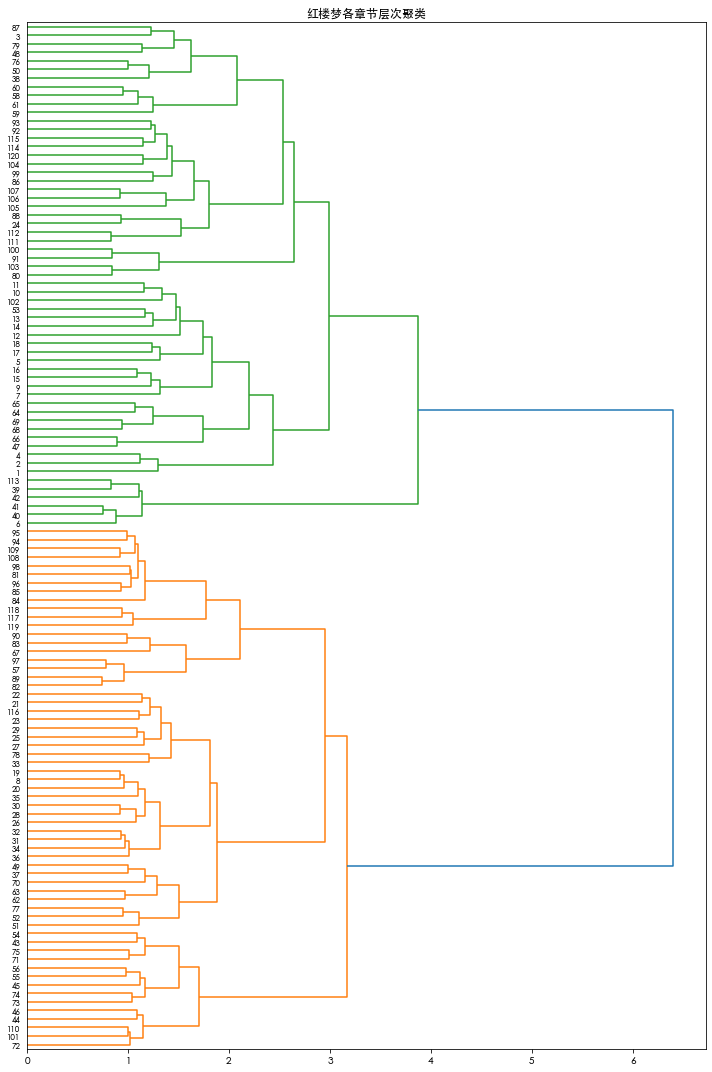

In [21]:
from scipy.cluster.hierarchy import dendrogram,ward
from scipy.spatial.distance import pdist,squareform

## 标签，每个章节的标题
labels = data.chapter_number.values

#计算每章的距离矩阵
cos_distance_matrix = squareform(pdist(word_vectors,'cosine'))

## 根据距离聚类
ward_results = ward(cos_distance_matrix)  

## 聚类结果可视化
fig, ax = plt.subplots(figsize=(10, 15))

ax = dendrogram(ward_results,orientation='right', labels=labels);
plt.yticks(size = 8)
plt.title("红楼梦各章节层次聚类")

plt.tight_layout()
plt.show()   

层次聚类可以清晰地表示章节之间的层次关系，章节和距离最近的章节进行合并，不断递归形成树。从层次聚类树形图中我们可以看出《红楼梦》哪些回最为接近，如114回和115回的距离最为接近，117回和118回的距离最为接近等等...

# 4.总结

在本案例中，我们首先对红楼梦120回的文本数据进行了清洗和格式的整理；接着宏观了分析了其中的章节结构、次数和字数等基本情况；然后通过分词、分析词频并通过可视化的方法进行展示；最后通过两种聚类方法对各章节的文本进行聚类，使用两种降维方式对聚类结果进行验证和可视化。《红楼梦》被评为中国古典章回小说的巅峰之作，思想价值和艺术价值极高。关于红楼梦的研究一直是中国传统文学的热点，红学家们众说纷纭，思想观点百花齐放，在此案例中我们从统计分析和文本挖掘等角度对红楼梦进行了一些简单的分析。此外关于小说中人物的社交关系也是一大热点，在下一个案例中我们尝试通过图与网络结构对红楼梦中的人物关系进行分析。